# Gradient Descent

решение уравнений методом вариаций и градиентного спуска

In [349]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [350]:
import physics as ph
from Sun import SSM18 as s

In [351]:
pi = math.pi
Z = s.Z

In [352]:
def load_model(epoch):
    filename = 'Mass/1epoch%.02d.csv' % epoch
    return pd.read_csv(filename)
epoch = 0
df = load_model(epoch)
dimM = len(df.index)
df

,Unnamed: 0,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0,0.000000e+00,0.000000e+00,1.333000e+07,94.554471,0.000000e+00,0.732,1.318613,0.0,1.730205e+17,8.561869e-11
1,1,1.989737e+30,1.720827e+09,1.323295e+07,93.267398,2.371017e+31,0.732,1.337635,0.0,1.694228e+17,8.186134e-11
2,2,3.979475e+30,2.170742e+09,1.317560e+07,92.506463,4.667612e+31,0.732,1.348390,0.0,1.673123e+17,7.971258e-11
3,3,5.969212e+30,2.487796e+09,1.312752e+07,91.867973,6.909218e+31,0.732,1.357124,0.0,1.655511e+17,7.795029e-11
4,4,7.958950e+30,2.741213e+09,1.308464e+07,91.297969,9.104061e+31,0.732,1.364692,0.0,1.639865e+17,7.640787e-11
...,...,...,...,...,...,...,...,...,...,...,...
996,996,1.981778e+33,5.478443e+10,8.884676e+05,0.065450,2.461129e+33,0.732,6.506261,1.0,7.982444e+12,2.801593e-22
997,997,1.983768e+33,5.565851e+10,7.779882e+05,0.053620,2.461129e+33,0.732,5.330260,1.0,5.726433e+12,5.617357e-23
998,998,1.985758e+33,5.672587e+10,6.475668e+05,0.040707,2.461129e+33,0.732,4.046600,1.0,3.618575e+12,6.097868e-24
999,999,1.987748e+33,5.818398e+10,4.769614e+05,0.025719,2.461129e+33,0.732,2.556699,1.0,1.683936e+12,1.506867e-25


In [353]:
x = df['Hydrogen'].values
m = df['Mass'].values
d = df['Density'].values
t = df['Temperature'].values
# v = df['Velocity'].values

In [354]:
r = np.zeros(dimM)
l = np.zeros(dimM)
p = np.zeros(dimM)
k = np.zeros(dimM)
v = np.zeros(dimM)

In [360]:
d1 = d.copy()
t1 = t.copy()
x1 = x.copy()
# Вычисляем величины r,l,p,k,c,v из x,m,d,t
r[0] = 0.
l[0] = 0.
for i in range(1, dimM):
    r[i] = pow(pow(r[i-1], 3) + 3*(m[i] - m[i-1])/4/pi/d1[i-1], 1/3) 
    l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d1[i]+d1[i-1]), 0.5*(t1[i]+t1[i-1]), x1[i], 1 - Z - x1[i], Z)
for i in range(dimM):
    X = x1[i]
    Y = 1 - Z -X
    p[i] = ph.Pressure(d1[i], t1[i], X, Y, Z)
    k[i] = ph.opacity(d1[i], t1[i], X, Y, Z)
    v[i] = 4*ph.m_prot*ph.Etot(d1[i], t1[i], X, Y, Z)/X/ph.dEpp*ph.year

In [363]:
a = np.zeros(dimM) # градиент давления
da = np.zeros(dimM) # несоответствие градиента давления
b = np.zeros(dimM) # градиент температуры
br = np.zeros(dimM) # градиент температуры при радиации
bc = np.zeros(dimM) # градиент температуры при конвекции
db = np.zeros(dimM) # несоответствие градиента температуры 

In [364]:
N = 20 #
M = 50
print('N*M+1 = dimM is '+ str(N*M+1 == dimM))

N*M+1 = dimM is True


In [459]:
def Error():
    # Вычисляем величины r,l,p,k,c,v из x1,m,d1,t1
    r[0] = 0.
    l[0] = 0.
    for i in range(1, dimM):
        r[i] = pow(pow(r[i-1], 3) + 3*(m[i] - m[i-1])/4/pi/d1[i-1], 1/3) 
        l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d1[i]+d1[i-1]), 0.5*(t1[i]+t1[i-1]), x1[i], 1 - Z - x1[i], Z)
    for i in range(dimM):
        X = x1[i]
        Y = 1 - Z - X
        p[i] = ph.Pressure(d1[i], t1[i], X, Y, Z)
        k[i] = ph.opacity(d1[i], t1[i], X, Y, Z)
        v[i] = 4*ph.m_prot*ph.Etot(d1[i], t1[i], X, Y, Z)/X/ph.dEpp*ph.year
    sa = 0
    sb = 0
    for i in range(1, dimM-1):
        X = x1[i]
        Y = 1 - Z - X
        mu = ph.MU(X, Y, Z)
        a[i] = -ph.G*m[i]*d1[i]/pow(r[i], 2)
        da[i] = (p[i+1] - p[i])/2/(r[i+1] - r[i]) + (p[i] - p[i-1])/2/(r[i] - r[i-1])
        br[i] = -3/16*k[i]*d1[i]*l[i]/ph.sigma/pow(t1[i], 3)/4/pi/pow(r[i], 2)
        bc[i] = -0.4*mu/ph.kB*ph.m_prot*ph.G*m[i]/pow(r[i], 2)
        if abs(br[i]) < abs(bc[i]):
            b[i] = br[i]
        else:
            b[i] = bc[i]
        db[i] = (t1[i+1] - t1[i])/2/(r[i+1] - r[i]) + (t1[i] - t1[i-1])/2/(r[i] - r[i-1])
#         sa += pow((da[i] - a[i])*(db[i] - b[i]), 2)
        sa += pow((da[i] - a[i]), 2)
        sb += pow((db[i] - b[i]), 2)
#     print(sa, sb)
#     return 0.5*(sa/838897020508.5634 + sb/8.284019085256349e-09)
    return sa*sb/6949.4389284576255
#     return sa/355.3047197588518

In [460]:
def factor(i, j):
    n = abs(i - j*M)
    if n >= M:
        return 0.
    return 1. - n/M

In [467]:
NG = 300 
err = np.zeros(NG)
count = 0
k0 = 2e-6
ed = np.zeros(N+1)
et = np.zeros(N+1)
x1 = df['Hydrogen'].values.copy()
d1 = df['Density'].values.copy()
t1 = df['Temperature'].values.copy()
v = df['Velocity'].values.copy()
x1 = x1*np.exp(-1e9*v)

In [468]:
count = 0
err[count] = Error()
err[count]

9581.638131342685

In [ ]:
%%time
while count < NG:
    
    d2 = d1.copy()
    t2 = t1.copy()
    
    for j in range(N+1):
        for i in range(dimM):
            d1[i] = d2[i] + 0.001*factor(i, j)*d2[i]
        ed[j] = Error() - err[count]
    
    d1 = d2.copy()
    for j in range(N+1):
        for i in range(dimM):
            t1[i] = t2[i] + 0.001*factor(i, j)*t2[i]
        et[j] = Error() - err[count]   
#     print(ed, et)
    d1 = d2.copy()
    t1 = t2.copy()
    for i in range(dimM):
        for j in range(N+1):
            f = factor(i, j)
            d1[i] -= k0*f*ed[j]*d2[i]
            t1[i] -= k0*f*et[j]*t2[i]
    err0 = err[count]
    count += 1
    err1 = Error()
    
    err[count] = err1
    print('count=%d Error=%.2f Ratio=%.3f' % (count, err[count], 100*err0/err1 - 100.))
    if err0 <= err1:
        break

count=1 Error=8622.72 Ratio=11.121
count=2 Error=7874.93 Ratio=9.496
count=3 Error=7307.71 Ratio=7.762
count=4 Error=6792.29 Ratio=7.588
count=5 Error=6357.08 Ratio=6.846
count=6 Error=5984.27 Ratio=6.230
count=7 Error=5661.68 Ratio=5.698
count=8 Error=5379.88 Ratio=5.238
count=9 Error=5131.66 Ratio=4.837
count=10 Error=4911.57 Ratio=4.481
count=11 Error=4715.32 Ratio=4.162
count=12 Error=4539.28 Ratio=3.878
count=13 Error=4381.48 Ratio=3.602
count=14 Error=4238.55 Ratio=3.372
count=15 Error=4108.54 Ratio=3.164
count=16 Error=3989.78 Ratio=2.977
count=17 Error=3880.89 Ratio=2.806
count=18 Error=3780.76 Ratio=2.648
count=19 Error=3688.40 Ratio=2.504
count=20 Error=3602.90 Ratio=2.373
count=21 Error=3523.62 Ratio=2.250
count=22 Error=3449.92 Ratio=2.136
count=23 Error=3381.19 Ratio=2.033
count=24 Error=3316.98 Ratio=1.936
count=25 Error=3256.31 Ratio=1.863
count=26 Error=3199.91 Ratio=1.763
count=27 Error=3146.42 Ratio=1.700
count=28 Error=3096.08 Ratio=1.626
count=29 Error=3048.62 Ratio

In [457]:
df1 = pd.DataFrame({'Mass': m, 'Radius': r, 'Temperature': t1, 'Density': d1, 
          'Luminosity': l, 'Hydrogen': x1, 'Opacity': k, 'Pressure': p, 'Velocity': v})
df1

,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Pressure,Velocity
0,0.000000e+00,0.000000e+00,1.314883e+07,95.458615,0.000000e+00,0.671935,1.401858,1.645078e+17,7.497410e-11
1,1.989737e+30,1.707251e+09,1.305358e+07,94.137110,1.928672e+31,0.674465,1.419072,1.613765e+17,7.196392e-11
2,3.979475e+30,2.156022e+09,1.299749e+07,93.347141,3.797829e+31,0.675915,1.428548,1.595167e+17,7.022883e-11
3,5.969212e+30,2.472270e+09,1.295055e+07,92.681067,5.628291e+31,0.677108,1.436127,1.579543e+17,6.879872e-11
4,7.958950e+30,2.725056e+09,1.290873e+07,92.084377,7.425970e+31,0.678153,1.442610,1.565590e+17,6.754189e-11
...,...,...,...,...,...,...,...,...,...
996,1.981778e+33,5.438794e+10,8.884676e+05,0.065450,2.203801e+33,0.732000,6.506261,7.982442e+12,2.801571e-22
997,1.983768e+33,5.519378e+10,7.779882e+05,0.053620,2.203801e+33,0.732000,5.330260,5.726433e+12,5.617353e-23
998,1.985758e+33,5.614659e+10,6.475668e+05,0.040707,2.203801e+33,0.732000,4.046600,3.618575e+12,6.097839e-24
999,1.987748e+33,5.735430e+10,4.769614e+05,0.025719,2.203801e+33,0.732000,2.556699,1.683936e+12,1.506852e-25


In [409]:
epoch = 1
_ = df1.to_csv(line_terminator='\n')
filename = "Mass/1epoch%.02d.csv" % epoch
print(filename)
csv_file = open(filename, "wt")
n = csv_file.write(_)
csv_file.close()

Mass/1epoch01.csv


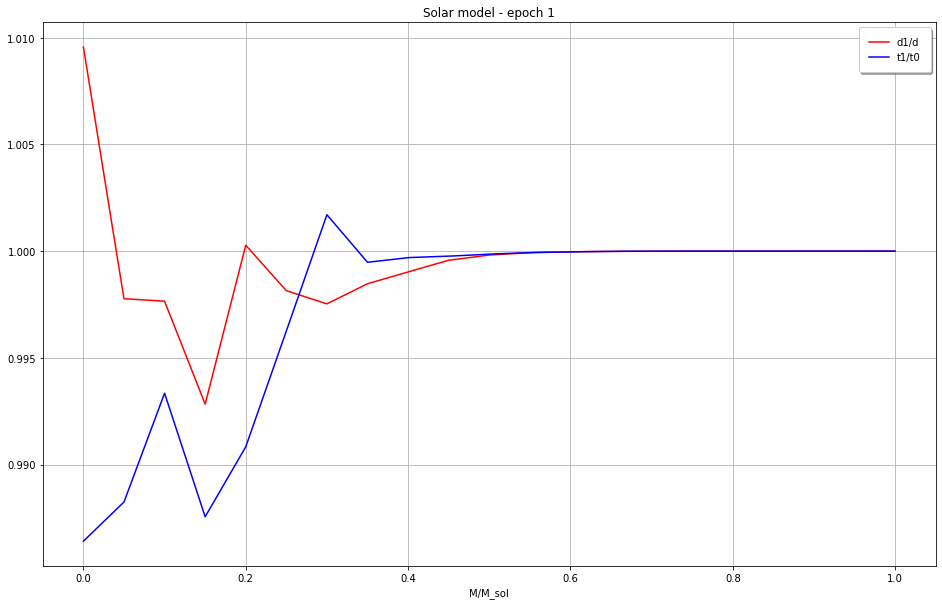

In [458]:
m1 = m/s.M
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m1, d1/d, color='red', label='d1/d')
plt.plot(m1, t1/t, color='blue', label='t1/t0')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Solar model - epoch %d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);